In [3]:
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import make_scorer, accuracy_score, recall_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay

In [4]:
df = pd.read_csv("minas.csv")
df = df.rename(columns={"V": "Voltage", "H": "Height", "S": "Soil Type", "M" : "Mine type"})
df.shape

(338, 4)

In [3]:
df.head()

Voltage    Height  Soil Type  Mine type
0  0.338157  0.000000          1          1
1  0.320241  0.181818          1          1
2  0.287009  0.272727          1          1
3  0.256284  0.454545          1          1
4  0.262840  0.545455          1          1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Voltage    338 non-null    float64
 1   Height     338 non-null    float64
 2   Soil Type  338 non-null    int64  
 3   Mine type  338 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 10.7 KB


In [7]:
df.describe()

Voltage      Height   Soil Type   Mine type
count  338.000000  338.000000  338.000000  338.000000
mean     0.430634    0.508876    3.517751    2.952663
std      0.195819    0.306043    1.721218    1.419703
min      0.197734    0.000000    1.000000    1.000000
25%      0.309737    0.272727    2.000000    2.000000
50%      0.359516    0.545455    4.000000    3.000000
75%      0.482628    0.727273    5.000000    4.000000
max      0.999999    1.000000    6.000000    5.000000

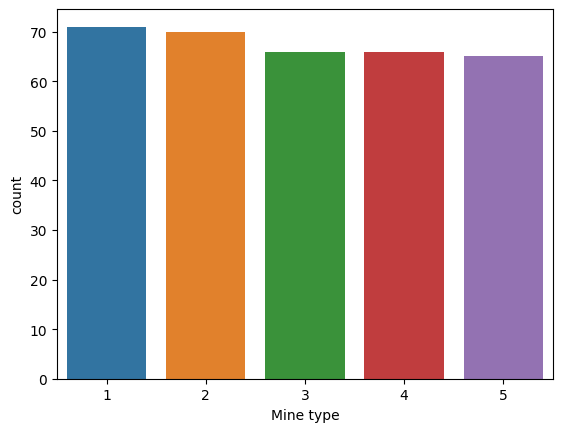

In [8]:
ax = sns.countplot(x = "Mine type", data=df)

In [9]:
df_corr = df.corr()
display(df_corr)

Voltage    Height  Soil Type  Mine type
Voltage    1.000000 -0.377523   0.070673  -0.144569
Height    -0.377523  1.000000  -0.006957   0.041326
Soil Type  0.070673 -0.006957   1.000000   0.017346
Mine type -0.144569  0.041326   0.017346   1.000000

<Axes: >

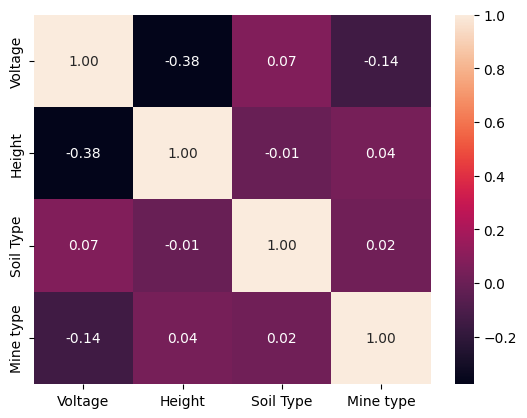

In [10]:
sns.heatmap(df_corr, fmt='.2f', annot=True)

In [11]:
df_cov = df.cov()
display(df_cov)

Voltage    Height  Soil Type  Mine type
Voltage    0.038345 -0.022625   0.023820  -0.040191
Height    -0.022625  0.093663  -0.003665   0.017956
Soil Type  0.023820 -0.003665   2.962592   0.042386
Mine type -0.040191  0.017956   0.042386   2.015557

<Axes: >

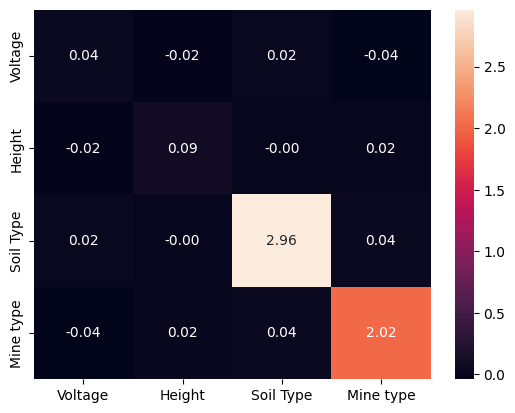

In [12]:
sns.heatmap(df_cov, fmt='.2f', annot=True)

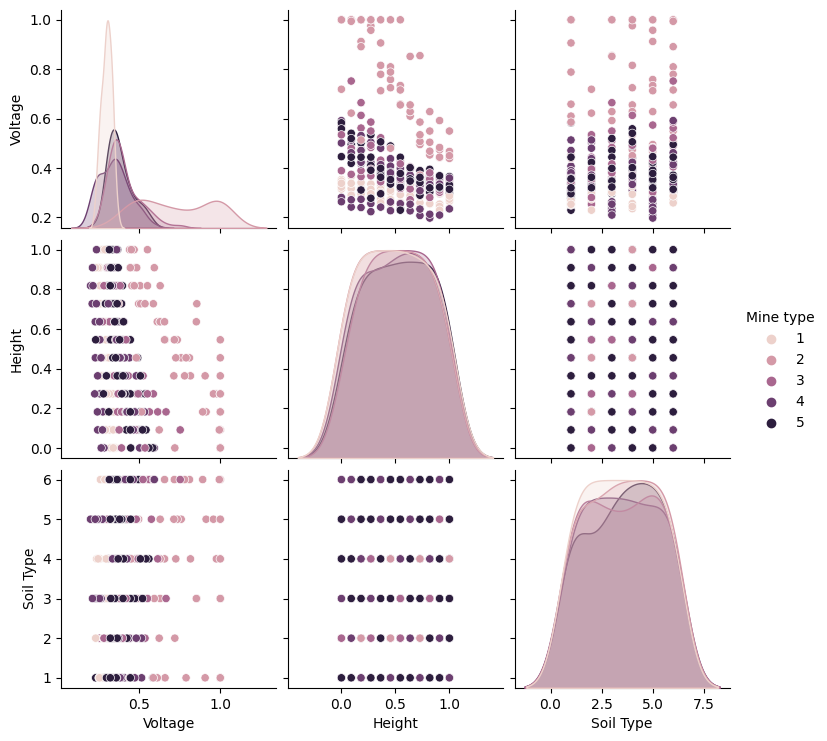

In [13]:
sns.pairplot(df, hue="Mine type")

Text(0.5, 1.0, 'Dispersão Voltage X Height')

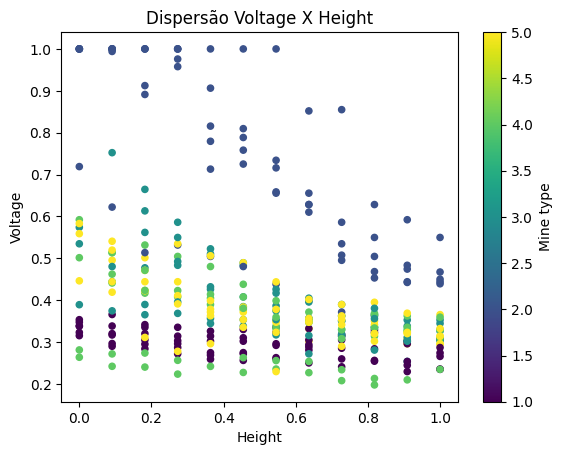

In [14]:
df.plot.scatter(x="Height", y="Voltage", c="Mine type", colormap="viridis")
plt.xlabel('Height')
plt.ylabel('Voltage')
plt.title("Dispersão Voltage X Height")

Text(0.5, 0.92, 'Dispersão 3D')

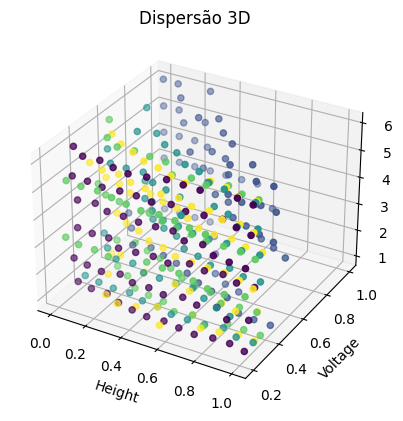

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df["Height"], df["Voltage"], df["Soil Type"], c=df["Mine type"], cmap="viridis")
ax.set_xlabel('Height')
ax.set_ylabel('Voltage')
ax.set_zlabel('Soil type')
ax.set_title('Dispersão 3D')

In [16]:
fig = px.scatter_3d(df, x="Height", y="Voltage", z="Soil Type", color="Mine type")
fig.update_layout(scene=dict(
    xaxis_title='Voltage',
    yaxis_title='Height',
    zaxis_title='Soil type'
))
fig.show()

In [17]:
X = df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = df["Mine type"]

In [18]:
model = ExtraTreesClassifier()
model.fit(X,y)

print(model.feature_importances_)

[0.80141498 0.11412209 0.08446293]


In [19]:
recall_scorer = make_scorer(recall_score, average='macro')

In [20]:
np.random.seed(42)

In [21]:
kf = StratifiedKFold(shuffle=True)

In [22]:
model = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3,5,7]}),
    "Tree": (DecisionTreeClassifier(), {"max_depth": [3,5,7], "criterion": ["gini", "entropy"]}),
    "SVM": (SVC(), {"degree": [3,6,8], "kernel": ["linear", "rbf"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [100,500,1000], "max_depth": [3,5,7], "criterion": ["gini", "entropy"]})
}

In [23]:
for model_name, (clf, parameters) in model.items():
    means = {'accuracy': [], 'recall': []}
    
    for fold, (train,test) in enumerate(kf.split(X,y)):
        best = GridSearchCV(clf, parameters, n_jobs=-1, cv=kf, scoring=recall_scorer, return_train_score=True)
        best.fit(X[train], y[train])
        
        y_pred = best.predict(X[test])
        
        means['accuracy'].append(accuracy_score(y[test], y_pred))
        means['recall'].append(recall_score(y[test], y_pred, average='macro'))
        
        print(f"{fold+1} -- {model_name} -- \
        acc: {round(means['accuracy'][-1] * 100, 2)}% rec: {round(means['recall'][-1] * 100, 2)}% Best parameters {best.best_params_}")
    
    print(f"\n\tA média de acuracia do {model_name} foi de {sum(means['accuracy'])/len(means['accuracy'])*100}%")
    print(f"\tA média de recall do {model_name} foi de {sum(means['recall'])/len(means['recall'])*100}%")
    print("--------------------------------")

1 -- KNN --         acc: 44.12% rec: 42.48% Best parameters {'n_neighbors': 3}
2 -- KNN --         acc: 44.12% rec: 43.41% Best parameters {'n_neighbors': 3}
3 -- KNN --         acc: 41.18% rec: 40.66% Best parameters {'n_neighbors': 3}
4 -- KNN --         acc: 37.31% rec: 36.37% Best parameters {'n_neighbors': 3}
5 -- KNN --         acc: 40.3% rec: 39.23% Best parameters {'n_neighbors': 3}

	A média de acuracia do KNN foi de 41.40474100087796%
	A média de recall do KNN foi de 40.430769230769236%
--------------------------------
1 -- Tree --         acc: 45.59% rec: 44.65% Best parameters {'criterion': 'entropy', 'max_depth': 7}
2 -- Tree --         acc: 45.59% rec: 45.05% Best parameters {'criterion': 'entropy', 'max_depth': 7}
3 -- Tree --         acc: 60.29% rec: 59.67% Best parameters {'criterion': 'entropy', 'max_depth': 7}
4 -- Tree --         acc: 52.24% rec: 51.54% Best parameters {'criterion': 'gini', 'max_depth': 7}
5 -- Tree --         acc: 56.72% rec: 55.93% Best parameters

# REFATORANDO O DATASET
Modificando para ficar apenas dois labels. 0 = Não mina, 1 = Mina

In [24]:
aux = df["Mine type"].replace({1: 0, 2: 1, 3: 1, 4: 1, 5: 1})

In [25]:
X = df[["Voltage", "Height", "Soil Type"]]
y = aux

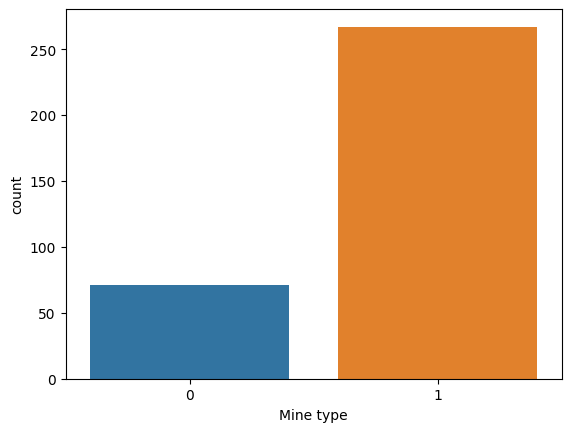

In [26]:
ax = sns.countplot(x = "Mine type", data=pd.concat([X,y], axis=1))

In [27]:
smt = SMOTE(random_state=42)
X,y = smt.fit_resample(X,y)
new_df = pd.concat([X,y], axis=1)
new_df.shape

(534, 4)

In [28]:
new_df.head()

Voltage    Height  Soil Type  Mine type
0  0.338157  0.000000          1          0
1  0.320241  0.181818          1          0
2  0.287009  0.272727          1          0
3  0.256284  0.454545          1          0
4  0.262840  0.545455          1          0

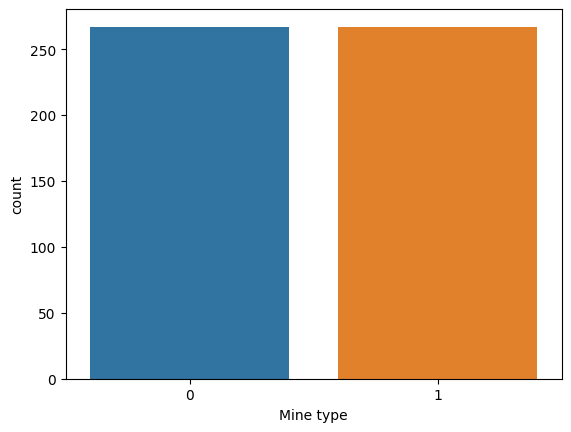

In [31]:
ax = sns.countplot(x = "Mine type", data=new_df)

In [32]:
df_corr = new_df.corr()
display(df_corr)

Voltage    Height  Soil Type  Mine type
Voltage    1.000000 -0.291987   0.056154   0.498624
Height    -0.291987  1.000000  -0.008520   0.059402
Soil Type  0.056154 -0.008520   1.000000  -0.012067
Mine type  0.498624  0.059402  -0.012067   1.000000

<Axes: >

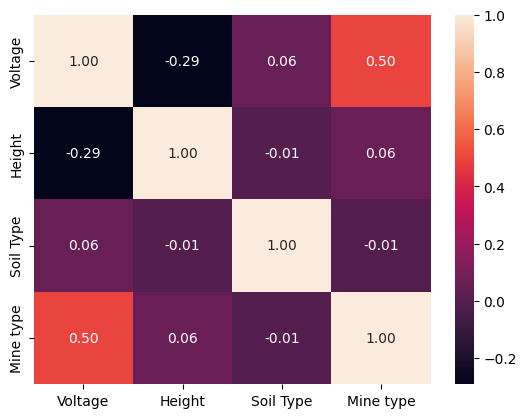

In [34]:
sns.heatmap(df_corr, fmt='.2f', annot=True)

In [35]:
df_cov = new_df.cov()
display(df_cov)

Voltage    Height  Soil Type  Mine type
Voltage    0.028643 -0.014541   0.016238   0.042234
Height    -0.014541  0.086586  -0.004283   0.008748
Soil Type  0.016238 -0.004283   2.919384  -0.010319
Mine type  0.042234  0.008748  -0.010319   0.250469

<Axes: >

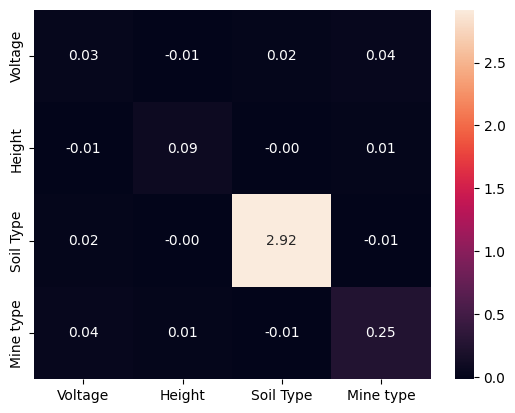

In [36]:
sns.heatmap(df_cov, fmt='.2f', annot=True)

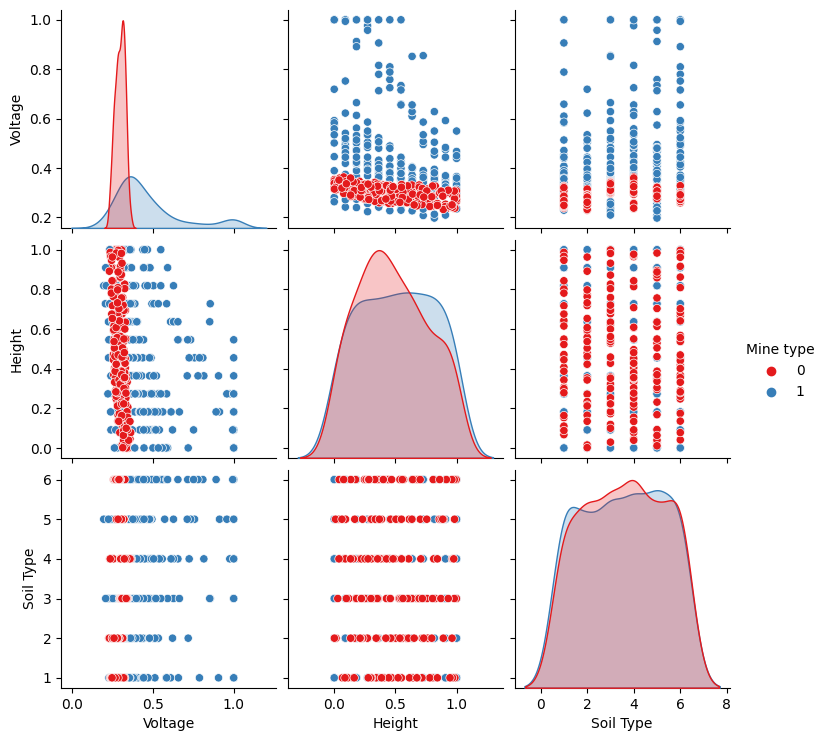

In [37]:
sns.pairplot(data=new_df, hue="Mine type", palette="Set1")

In [39]:
X = new_df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = new_df['Mine type']

In [40]:
model = {
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3,5,7]}),
    "Tree": (DecisionTreeClassifier(), {"max_depth": [3,5,7], "criterion": ["gini", "entropy"]}),
    "SVM": (SVC(), {"degree": [3,6,8], "kernel": ["linear", "rbf"]}),
    "Gauss": (GaussianNB(priors=[0.3,0.7]), {}),
    "LogisticRegression": (LogisticRegression(), {"penalty": ["l2", None], "solver": ["lbfgs", "newton-cg", "newton-cholesky", "sag", "saga"]}),
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [100,500,1000], "max_depth": [3,5,7], "criterion": ["gini", "entropy"]})
}

In [41]:
for model_name, (clf, parameters) in model.items():
    means = {'accuracy': [], 'recall': []}
    
    for fold, (train,test) in enumerate(kf.split(X,y)):
        best = GridSearchCV(clf, parameters, n_jobs=-1, cv=kf, scoring="recall", return_train_score=True)
        best.fit(X[train], y[train])
        
        y_pred = best.predict(X[test])
        
        means['accuracy'].append(accuracy_score(y[test], y_pred))
        means['recall'].append(recall_score(y[test], y_pred))
        
        print(f"{fold+1} -- {model_name} -- \
        acc: {round(means['accuracy'][-1] * 100, 2)}% rec: {round(means['recall'][-1] * 100, 2)}% Best parameters {best.best_params_}")
    
    print(f"\n\tA média de acuracia do {model_name} foi de {sum(means['accuracy'])/len(means['accuracy'])*100}%")
    print(f"\tA média de recall do {model_name} foi de {sum(means['recall'])/len(means['recall'])*100}%")
    print("--------------------------------")

1 -- KNN --         acc: 79.44% rec: 69.81% Best parameters {'n_neighbors': 3}
2 -- KNN --         acc: 74.77% rec: 62.26% Best parameters {'n_neighbors': 3}
3 -- KNN --         acc: 80.37% rec: 66.67% Best parameters {'n_neighbors': 3}
4 -- KNN --         acc: 81.31% rec: 66.67% Best parameters {'n_neighbors': 3}
5 -- KNN --         acc: 85.85% rec: 75.47% Best parameters {'n_neighbors': 3}

	A média de acuracia do KNN foi de 80.34738141421265%
	A média de recall do KNN foi de 68.17610062893081%
--------------------------------
1 -- Tree --         acc: 92.52% rec: 86.79% Best parameters {'criterion': 'entropy', 'max_depth': 7}
2 -- Tree --         acc: 95.33% rec: 94.34% Best parameters {'criterion': 'entropy', 'max_depth': 7}
3 -- Tree --         acc: 91.59% rec: 88.89% Best parameters {'criterion': 'gini', 'max_depth': 7}
4 -- Tree --         acc: 90.65% rec: 87.04% Best parameters {'criterion': 'gini', 'max_depth': 7}
5 -- Tree --         acc: 94.34% rec: 94.34% Best parameters {'

# Buscando os melhores parametros para RandomForest

In [35]:
X = new_df[["Voltage", "Height", "Soil Type"]].to_numpy()
y = new_df['Mine type']

In [36]:
params = {
    'n_estimators' : [50, 100, 150, 500],
    'max_depth'    : [None, 3, 5, 7, 9, 11, 13, 15],
    'class_weight' : [None, 'balanced', 'balanced_subsample'],
    'criterion'    : ['gini', 'entropy'],
    'max_features' : [None, 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'oob_score': [False, True],
}

In [37]:
best = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, cv=kf, scoring="recall", return_train_score=True)
best.fit(X, y)

print("\n O Melhor estimador:\n", best.best_estimator_)
print("\n O melhor score:\n", best.best_score_)
print("\n Os melhores parametros:\n", best.best_params_)


 O Melhor estimador:
 RandomForestClassifier(class_weight='balanced_subsample', max_depth=13,
                       max_features=None, min_samples_split=5, oob_score=True)

 O melhor score:
 0.9289308176100629

 Os melhores parametros:
 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'oob_score': True}


fold: 1	 acc: 94.39252336448598	 rec: 92.45283018867924
fold: 2	 acc: 92.5233644859813	 rec: 88.67924528301887
fold: 3	 acc: 90.65420560747664	 rec: 87.03703703703704
fold: 4	 acc: 93.45794392523365	 rec: 88.88888888888889
fold: 5	 acc: 89.62264150943396	 rec: 90.56603773584906

Accuracy Score	 92.1301357785223
Recall Score	 89.52480782669461


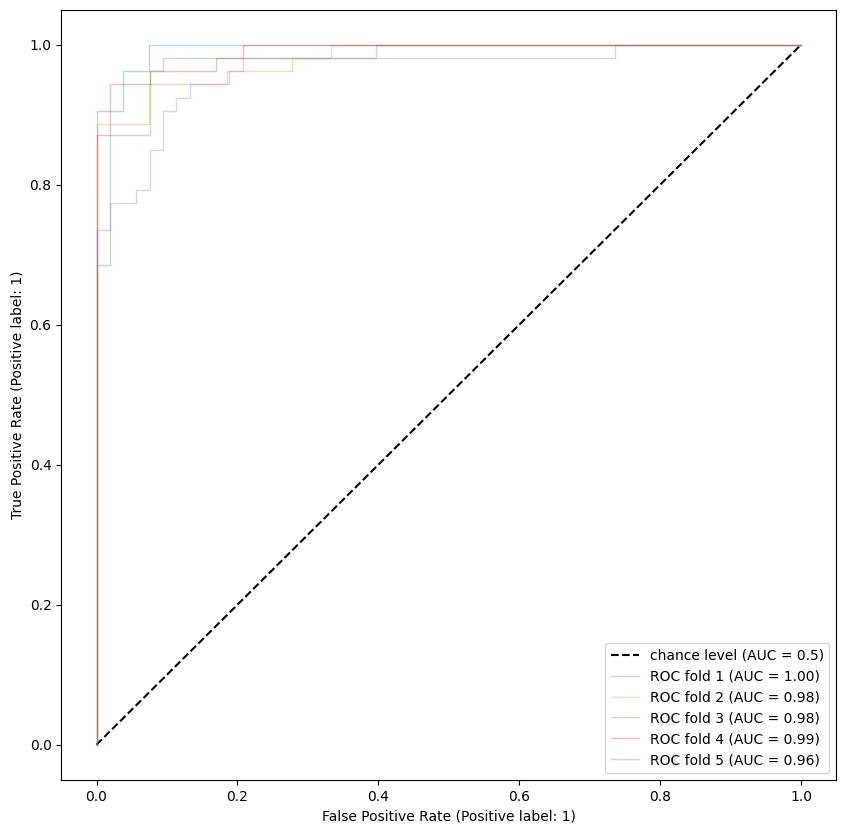

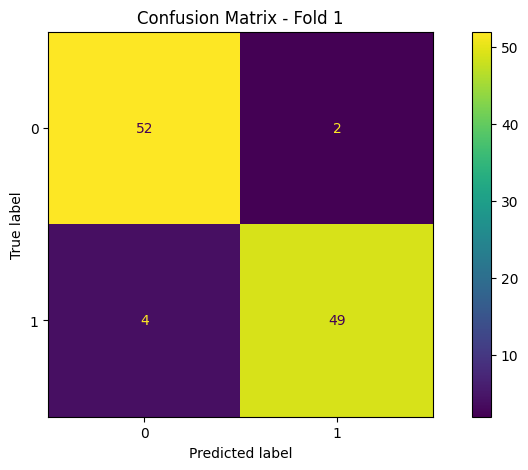

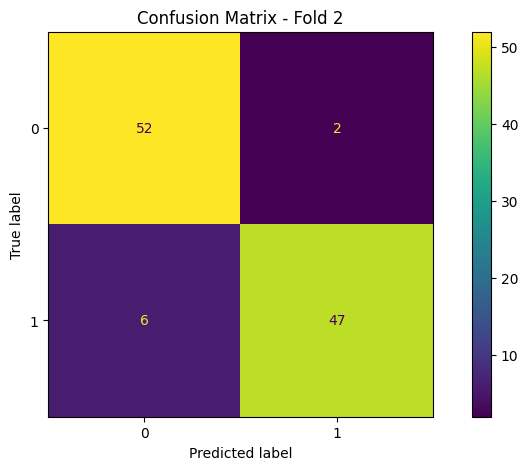

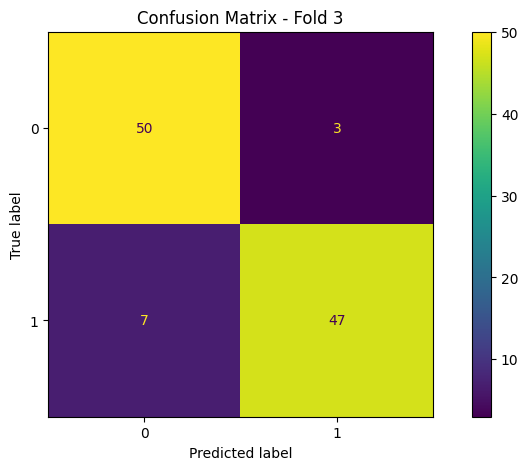

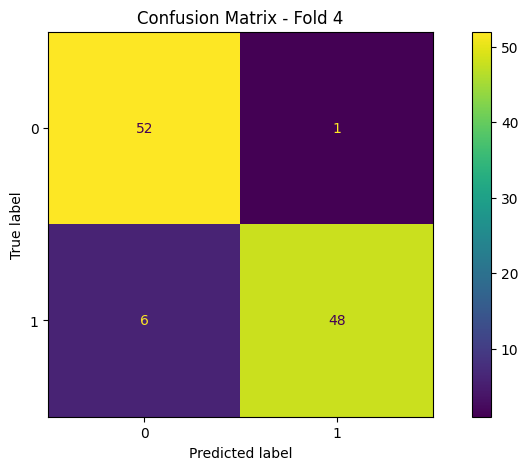

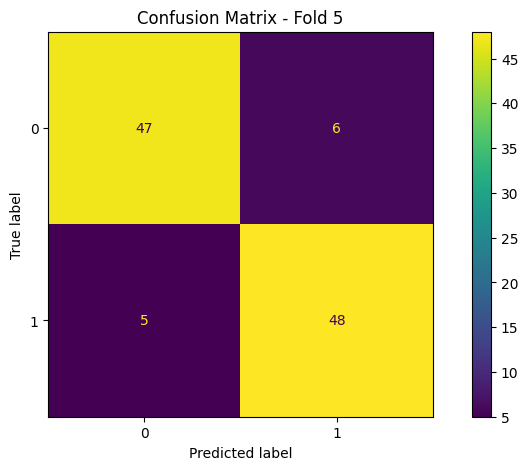

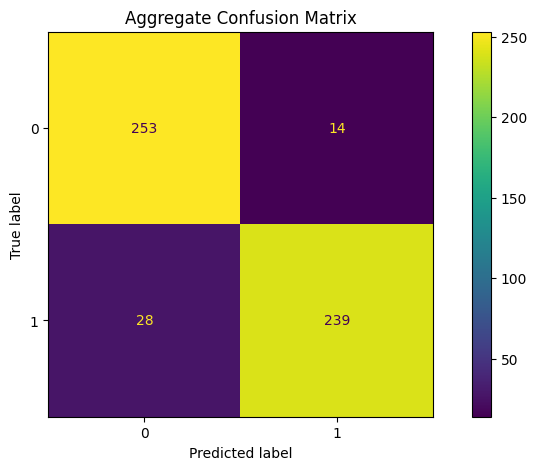

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    
means = {'accuracy': [], 'recall': []}
confusion_matrices = []

clf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2', min_samples_split=5, n_estimators=50, oob_score=True)

for fold, (train,test) in enumerate(kf.split(X,y)):
    clf.fit(X[train], y[train])

    y_pred = clf.predict(X[test])

    accuracy = accuracy_score(y[test], y_pred)
    recall = recall_score(y[test], y_pred)

    print(f"fold: {fold + 1}\t acc: {accuracy * 100}\t rec: {recall * 100}")

    means['accuracy'].append(accuracy)
    means['recall'].append(recall)

    confusion_matrices.append(confusion_matrix(y[test], y_pred))

    viz = RocCurveDisplay.from_estimator(
       clf,
       X[test],
       y[test],
       name=f"ROC fold {fold + 1}",
       alpha=0.3,
       lw=1,
       ax=ax,
    )

    fig2, ax2 = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y[test], y_pred, ax=ax2)
    ax2.set_title(f"Confusion Matrix - Fold {fold + 1}")
    
aggregate_confusion_matrix = np.sum(confusion_matrices, axis=0)
fig3, ax3 = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay(aggregate_confusion_matrix, display_labels=clf.classes_).plot(ax=ax3)
ax3.set_title("Aggregate Confusion Matrix")

print(f"\nAccuracy Score\t {sum(means['accuracy']) / len(means['accuracy']) * 100}")
print(f"Recall Score\t {sum(means['recall']) / len(means['recall']) * 100}")

# Treinando e Exportando a IA

In [43]:
clf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2', min_samples_split=5, n_estimators=50, oob_score=True)
clf.fit(X, y)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='log2',
                       min_samples_split=5, n_estimators=50, oob_score=True)

In [44]:
filename = "model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(clf, file)